In [97]:
import polars as pl
import polars.selectors as cs
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [98]:
df = (
    pl.scan_csv("/kaggle/input/kepler-exoplanet-search-results/cumulative.csv")
    .drop(["rowid", "kepid", "kepoi_name", "kepler_name"])
    .collect()
)
target_col = "koi_disposition"
target_names = df.get_column(target_col).unique(maintain_order=True)
target_names

koi_disposition
str
"""CONFIRMED"""
"""FALSE POSITIVE"""
"""CANDIDATE"""


In [99]:
df = (
    df
    .cast({cs.string(): pl.Categorical})
    .with_columns(cs.categorical().to_physical())
)
df

koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
u32,u32,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,f64,f64,f64,f64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,1.0,0,0,0,0,9.488036,0.000028,-0.000028,170.53875,0.00216,-0.00216,0.146,0.318,-0.146,2.9575,0.0819,-0.0819,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,null,null,93.59,29.45,-16.65,35.8,1,0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
0,0,0.969,0,0,0,0,54.418383,0.0002479,-0.000248,162.51384,0.00352,-0.00352,0.586,0.059,-0.443,4.507,0.116,-0.116,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,null,null,9.11,2.87,-1.62,25.8,2,0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,0.0,0,1,0,0,19.89914,0.000015,-0.000015,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.7822,0.0341,-0.0341,10829.0,171.0,-171.0,14.6,3.92,-1.31,638.0,null,null,39.3,31.04,-10.49,76.3,1,0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
1,1,0.0,0,1,0,0,1.736952,2.6300e-7,-2.6300e-7,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.5,-2.83,1395.0,null,null,891.96,668.95,-230.35,505.6,1,0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.28521,15.597
0,0,1.0,0,0,0,0,2.525592,0.000004,-0.000004,171.59555,0.00113,-0.00113,0.701,0.235,-0.478,1.6545,0.042,-0.042,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,null,null,926.16,874.33,-314.24,40.9,1,0,6031.0,169.0,-211.0,4.438,0.07,-0.21,1.046,0.334,-0.133,288.75488,48.2262,15.509
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,1,0.0,0,0,0,1,8.5898708,0.0001846,-0.000185,132.0161,0.0157,-0.0157,0.765,0.023,-0.541,4.806,0.634,-0.634,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,null,null,176.4,152.77,-77.6,8.4,1,0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
1,1,0.0,0,1,1,0,0.527699,1.1600e-7,-1.1600e-7,131.705093,0.00017,-0.00017,1.252,0.051,-0.049,3.2221,0.0174,-0.0174,1579.2,4.6,-4.6,29.35,7.7,-2.57,2088.0,null,null,4500.53,3406.38,-1175.26,453.3,1,0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
2,0,0.497,0,0,0,0,1.739849,0.0000178,-0.000018,133.00127,0.00769,-0.00769,0.043,0.423,-0.043,3.114,0.229,-0.229,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,null,null,1585.81,1537.86,-502.22,10.6,1,0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [100]:
y = df.get_column(target_col)
X = df.drop(target_col)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [101]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:0.77513	validation_1-mlogloss:0.78677
[1]	validation_0-mlogloss:0.58666	validation_1-mlogloss:0.60542
[2]	validation_0-mlogloss:0.46401	validation_1-mlogloss:0.48951
[3]	validation_0-mlogloss:0.38013	validation_1-mlogloss:0.40945
[4]	validation_0-mlogloss:0.31848	validation_1-mlogloss:0.35484
[5]	validation_0-mlogloss:0.27290	validation_1-mlogloss:0.31570
[6]	validation_0-mlogloss:0.23800	validation_1-mlogloss:0.28706
[7]	validation_0-mlogloss:0.21217	validation_1-mlogloss:0.26602
[8]	validation_0-mlogloss:0.19088	validation_1-mlogloss:0.25077
[9]	validation_0-mlogloss:0.17450	validation_1-mlogloss:0.24021
[10]	validation_0-mlogloss:0.16231	validation_1-mlogloss:0.23224
[11]	validation_0-mlogloss:0.15249	validation_1-mlogloss:0.22610
[12]	validation_0-mlogloss:0.14340	validation_1-mlogloss:0.22093
[13]	validation_0-mlogloss:0.13596	validation_1-mlogloss:0.21664
[14]	validation_0-mlogloss:0.12972	validation_1-mlogloss:0.21390
[15]	validation_0-mlogloss:0.12400	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

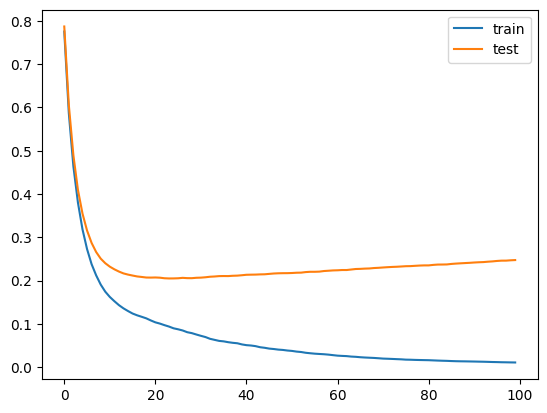

In [102]:
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train') # Not sure about the loss function
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()

In [103]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=target_names))

                precision    recall  f1-score   support

     CONFIRMED       0.81      0.84      0.82       689
FALSE POSITIVE       0.99      1.00      0.99      1502
     CANDIDATE       0.85      0.80      0.82       679

      accuracy                           0.91      2870
     macro avg       0.88      0.88      0.88      2870
  weighted avg       0.91      0.91      0.91      2870

